# Initial Design

This notebook contains the code used to select the reaction conditions tested for initial training of the GP. A modified latin hypercube sampling (LHS) strategy is used to select both discrete and continuous variables.  We previously demonstrated that several different designs work well for solvent selection, so LHS was chosen since it is already implemented by GPyOpt.  

## 1. Setup

Let's get everything loaded and ready to go.

In [1]:
#Autoreload automatically reloads any depdencies as you change them
%load_ext autoreload
%autoreload 2

In [28]:
#Import all the necessary packages
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, ContinuousVariable, DiscreteVariable, DescriptorsVariable
from summit.initial_design.latin_designer import LatinDesigner, lhs

from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [8]:
#Reduce solvent descriptors to 3 principal components
pca = PCA(n_components=3)
solvent_arr_std = solvent_ds.standardize()
solvent_arr_pca = pca.fit_transform(solvent_arr_std)

#Dataset manipulations
solvent_ds_pcs = DataSet({(f'PC_{i}', 'DATA'): solvent_arr_pca[:, i] for i in range(3)}, 
                         index=solvent_ds.index)
solvent_ds_pcs.columns.names = ['NAME', 'TYPE']
order = solvent_ds.columns.codes[0]
num_columns = len(solvent_ds.columns.levels[0])
solvent_ds_new = solvent_ds.copy()
solvent_ds_new.columns = solvent_ds.columns.set_codes(np.array([order.tolist(), [1]*num_columns]))
solvent_ds_pcs = solvent_ds_pcs.join(solvent_ds_new)

In [11]:
#Specify the optimization space

domain = Domain()

domain += ContinuousVariable(name='temperature',
                             description = "reaction temperature",
                             bounds=[20, 50])

domain += ContinuousVariable(name="acid_conc",
                             description = "propionic acid concentration",
                             bounds=[1,40])

domain += ContinuousVariable(name="cat_load",
                             description = "catalyst loading",
                             bounds=[0.1, 10])

domain += ContinuousVariable(name="co_cat_load",
                             description = "co-catalyst loading",
                             bounds=[15, 1500])

domain += ContinuousVariable(name="acrylate_amine_ratio",
                             description = "molar ratio of acrylate to amine",
                             bounds = [0.8, 2])


domain += ContinuousVariable(name="aldehyde_amine_ratio",
                             description = "molar ratio of aldehyde to amine",
                             bounds=[0.8, 2])

domain += DiscreteVariable(name="co_cat",
                           description="enumeration of the two potential cocatalysts",
                           levels = ['co_cat_1', 'co_cat_2'])


domain += DescriptorsVariable(name="solvent",
                             description="Descriptors of the solvent",
                             ds=solvent_ds_pcs)

domain #The domain should display as an html table 

Name,Type,Description,Values
temperature,"continuous, input",reaction temperature,"[20,50]"
acid_conc,"continuous, input",propionic acid concentration,"[1,40]"
cat_load,"continuous, input",catalyst loading,"[0.1,10]"
co_cat_load,"continuous, input",co-catalyst loading,"[15,1500]"
acrylate_amine_ratio,"continuous, input",molar ratio of acrylate to amine,"[0.8,2]"
aldehyde_amine_ratio,"continuous, input",molar ratio of aldehyde to amine,"[0.8,2]"
co_cat,"discrete, input",enumeration of the two potential cocatalysts,2 levels
solvent,"descriptors, input",Descriptors of the solvent,459 examples of 3 descriptors


## 2. Construct Initial Design

In [33]:
random_seed = 100
rs = np.random.RandomState(random_seed)
ld = LatinDesigner(domain, random_state=rs)
experiments = ld.generate_experiments(20)
experiments_ds = experiments.to_frame()
experiments

,temperature,acid_conc,cat_load,co_cat_load,acrylate_amine_ratio,aldehyde_amine_ratio,co_cat,cas_number
0,41.75,13.675,8.2675,943.125,1.67,1.73,co_cat_2,509-14-8
1,47.75,19.525,6.2875,571.875,1.73,1.43,co_cat_2,100-17-4
2,49.25,11.725,1.3375,349.125,1.43,1.25,co_cat_2,64-17-5
3,35.75,27.325,5.7925,423.375,1.07,1.79,co_cat_1,307-34-6
4,37.25,5.875,1.8325,1165.875,1.01,1.67,co_cat_1,126-33-0
5,43.25,1.975,9.7525,200.625,1.37,1.31,co_cat_1,307-34-6
6,25.25,17.575,0.8425,1388.625,1.19,1.97,co_cat_2,100-63-0
7,44.75,29.275,8.7625,1017.375,0.89,1.85,co_cat_1,132-64-9
8,20.75,3.925,2.8225,274.875,1.79,0.89,co_cat_1,75-25-2
9,29.75,39.025,2.3275,52.125,1.49,1.07,co_cat_2,519-73-3


## Analysis

In [34]:
random_seed = 100
rs = np.random.RandomState(random_seed)
n = domain.num_continuous_dimensions()
design = lhs(n, samples=20, criterion='center', random_state=rs)

(20, 9)

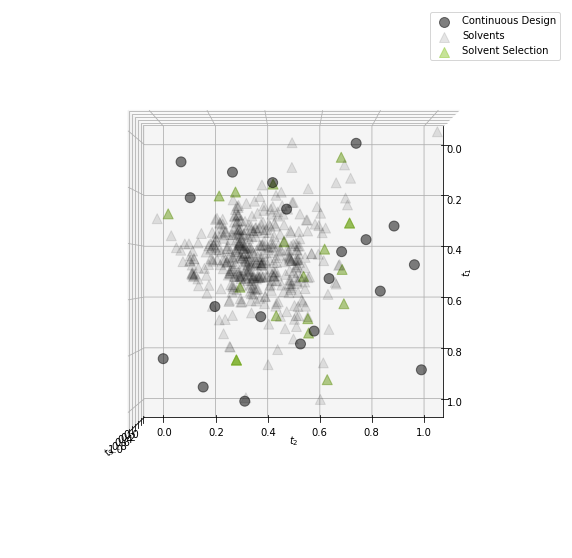

In [81]:
#Plot points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(design[:, 6], design[:, 7], design[:, 8], s=100, label='Continuous Design', color='k', alpha=0.5)
solvent_indices = experiments.get_indices('solvent')
solvent_design_pcs_full = solvent_ds_pcs.zero_to_one()
ax.scatter(solvent_design_pcs_full[:, 0], solvent_design_pcs_full[:, 1], solvent_design_pcs_full[:, 2],
           label='Solvents', s=100, marker = '^', alpha=0.1, color='k')
solvent_design_pcs = solvent_design_pcs_full[solvent_indices[:, 0], :]
ax.scatter(solvent_design_pcs[:, 0], solvent_design_pcs[:, 1], solvent_design_pcs[:, 2],
           label='Solvent Selection', s=100, marker = '^', color='#90c933', alpha=0.5)
ax.legend()
ax.set_xlabel(r'$t_1$'); ax.set_ylabel(r'$t_2$'); ax.set_zlabel(r'$t_3$')
ax.view_init(90, 0)

* **27 June 2019**: There is definitely a problem with the way I'm constructing the initial design currently. I place the principal components on zero-to-one scale for the latin hypercube design. However, the data really follows a normal distribution, so you end up selecting a lot of "extreme" solvents, often the same solvent twice or three times. In fact there is not even a single continuous point, placed in the range where most of the solvents lie in the principal component space. 
![](outputs/lhs_design_pca_plot_2.svg)